# Computer Vision Project - Classification of Flowers


In this project your objective is to create a model in order to classify flowers. Thiszip file contains all relevant data. 

1. The data contains two folders: *train* and *test*. The *train* folder consists of 5486-images to use for training while the *test* folder contains 1351-images you can use to test your model in a **train-test-split** validation style. We have omitted another set of 1352 validation images which we will use to benchmark your final models in the last lecture. 


2. We have provided you with two label files: *train_labels.csv* and *test_labels.csv*. Each file contains the filename of the corresponding image and the class label. In total we have **102 different classes** of flowers.  You can import the label files using the `import_labels()` function provided to you in this notebook.


3. Due to the large number of images, there is a good chance that you can not easily fit the entire training and testing data into RAM. We therefore give you an implementation of a `DataGenerator` class that can be used with keras. This class will read in the images from your hard-drive for each batch during during or testing. The class comes with some nice features that could improve your training significantly such as **image resizing**, **data augmentation** and **preprocessing**. Have a look at the code to find out how.

    Initialize data generators using labels and image source directory.

    `
    datagen_train = DataGenerator('train', y_train, batch_size, input_shape, ...)
    datagen_test = DataGenerator('test', y_test, batch_size, input_shape, ...)`

    Train your model using data generators.

    `model.fit(datagen_train, validation_data=datagen_test, ...)`
    
    
4. Select a suitable model for classification. It is up to you to decide all model parameters, such as **number of layers**, **number and size of filter** in each layer, using **pooling** or, **image-size**, **data-augmentation**, **learning rate**, ... 


5. **Document** your progress and your intermediate results (your failures and improvements). Describe why you selected certain model and training parameters, what worked, what did not work. Store the training history (loss and accuracy) and create corresponding plots. This documentation will be part of your final presentation and will be **graded**.


6. Feel free to explore the internet for suitable CNN models and re-use these ideas. If you use certain features we have not touched during the lecture such as Dropout, Residual Learning or Batch Normalization. Prepare a slide in your final presentation to explain in your own (basic) terms what these things to so we can all learn from your experience. **Notice:** Very large models might perform better but will be harder and slower to train. **Do not use a pre-trained model you find online!**


7. Prepare a notebook with your model such that we can use it in the final competition. This means, store your trained model using `model.save(...)`. Your saved models can be loaded via `tf.keras.models.load_model(...)`. We will then provide you with a new folder containing images (*validation*) and a file containing labels (*validation_labels.csv*) which have the same structure. Prepare a data generator for this validation data (test it using the test data) and supply it to the 
 `evaluate_model(model, datagen)` function provided to you.
 
 Your prepared notebook could look like this:
 
    `... import stuff 
    ... code to load the stored model ...
    y_validation = import_labels('validation_labels.csv')
    datagen_validation = DataGenerator('validation', y_validation, batch_size, input_shape)
    evaluate_model(model, datagen_validation)`


8. Prepare a 15-Minute presentation of your findings and final model presentation. A rough guideline what could be interesting to your audience:
    * Explain your models architecture (number of layers, number of total parameters, how long took it to train, ...)
    * Compare the training history of your experimentats visually
    * Explain your best model (why is it better)
    * Why did you take certain decision (parameters, image size, batch size, ...)
    * What worked, what did not work (any ideas why?)
    * **What did you learn?**
    



In [1]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import os
import numpy as np

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = image.load_img(img_path, target_size=self._target_dim)
            x = image.img_to_array(img)
           
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        if self._preprocess_func is not None:
            X = self._preprocess_func(X)

        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

In [3]:
from PIL import Image
img = Image.open('./train/image_00002.jpg')
print(img.size)

(625, 500)


In [4]:
import_labels('train_labels.csv')

{'image_05520.jpg': 87,
 'image_05319.jpg': 70,
 'image_03097.jpg': 11,
 'image_02923.jpg': 60,
 'image_04161.jpg': 52,
 'image_00614.jpg': 89,
 'image_03354.jpg': 8,
 'image_03952.jpg': 51,
 'image_03530.jpg': 30,
 'image_05858.jpg': 63,
 'image_06322.jpg': 50,
 'image_01749.jpg': 83,
 'image_07384.jpg': 94,
 'image_06268.jpg': 61,
 'image_03317.jpg': 8,
 'image_06794.jpg': 21,
 'image_05119.jpg': 2,
 'image_02663.jpg': 58,
 'image_05021.jpg': 59,
 'image_03786.jpg': 37,
 'image_02155.jpg': 75,
 'image_01345.jpg': 51,
 'image_07915.jpg': 100,
 'image_06153.jpg': 19,
 'image_03986.jpg': 51,
 'image_00953.jpg': 46,
 'image_03316.jpg': 8,
 'image_01505.jpg': 44,
 'image_03461.jpg': 30,
 'image_08142.jpg': 57,
 'image_05836.jpg': 38,
 'image_01122.jpg': 46,
 'image_04944.jpg': 20,
 'image_07647.jpg': 96,
 'image_03998.jpg': 12,
 'image_06821.jpg': 24,
 'image_07962.jpg': 101,
 'image_05330.jpg': 70,
 'image_03246.jpg': 65,
 'image_00417.jpg': 73,
 'image_07329.jpg': 94,
 'image_02432.jpg'

In [5]:
datagen_train = DataGenerator('./train', import_labels('train_labels.csv'), 64, (221, 221))
datagen_test = DataGenerator('./test', import_labels('test_labels.csv'), 64, (221, 221))

In [6]:
datagen_train

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, GlobalAveragePooling2D, Flatten, MaxPool2D, MaxPool1D, Input, BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from os import listdir
from os.path import isfile, join


In [8]:
model = keras.Sequential()

# Note, we have to tell keras the correct input shape which is the dimension of our images
model.add(Input(shape=(221, 221, 3)))

# Add a convolutional layer with 16 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(BatchNormalization())

# Add a convolutional layer with 16 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(BatchNormalization())

# Convert to fully.connected network
model.add(GlobalAveragePooling2D())

# Add classifier part

# The number of output neurons must be equal to the number of classes
model.add(Dense(102, activation='softmax')) # Softmax: alle 10 Outputs summieren zu 1

In [9]:
opt = Adam(learning_rate=0.01) # Adaptive Moments; learning rate: wie groß sind die Schritte, 0.0001 auch möglich
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                        

In [10]:
history = model.fit(datagen_train, validation_data=datagen_test, epochs=30)

Epoch 1/30
85/85 [==============================] - 272s 3s/step - loss: 3.5579 - accuracy: 0.1722 - val_loss: 18.2166 - val_accuracy: 0.0685
Epoch 2/30
85/85 [==============================] - 290s 3s/step - loss: 2.8851 - accuracy: 0.2858 - val_loss: 3.9983 - val_accuracy: 0.1793
Epoch 3/30
85/85 [==============================] - 284s 3s/step - loss: 2.5303 - accuracy: 0.3562 - val_loss: 4.6084 - val_accuracy: 0.1391
Epoch 4/30
85/85 [==============================] - 267s 3s/step - loss: 2.3139 - accuracy: 0.4051 - val_loss: 3.1553 - val_accuracy: 0.2708
Epoch 5/30
85/85 [==============================] - 267s 3s/step - loss: 2.1478 - accuracy: 0.4414 - val_loss: 2.7358 - val_accuracy: 0.3460
Epoch 6/30
85/85 [==============================] - 307s 4s/step - loss: 1.9725 - accuracy: 0.4776 - val_loss: 2.7085 - val_accuracy: 0.3542
Epoch 7/30
85/85 [==============================] - 295s 3s/step - loss: 1.7972 - accuracy: 0.5239 - val_loss: 2.7910 - val_accuracy: 0.3728
Epoch 8/30
8

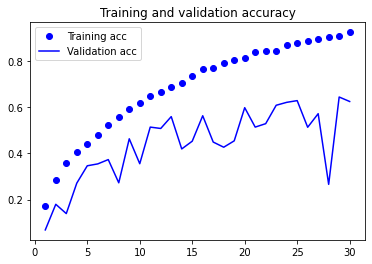

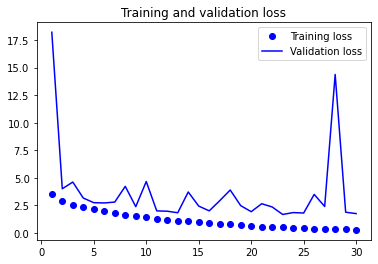

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

 

epochs = range(1, len(acc) + 1)

 

plt.plot(epochs, acc, 'bo', label='Training acc')

plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')

plt.legend()

 

plt.figure()

 

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend()